In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
import xrfdc
import time

from overlay.phase_correction_unified_overlay import phase_correction_unified_overlay
base = phase_correction_unified_overlay('overlay/unified_overlay.bit')

base.init_rf_clks()

In [3]:
base.ip_dict

{'radio/avgs_config_writer': {'type': 'xilinx.com:hls:passer_config_writer:1.0',
  'mem_id': 's_axi_a',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_S_AXI_A_ADDR_WIDTH': '5',
   'C_S_AXI_A_DATA_WIDTH': '32',
   'Component_Name': 'base_avgs_config_writer_0',
   'clk_period': '3.17',
   'machine': '64',
   'combinational': '0',
   'latency': '1',
   'II': 'x',
   'EDK_IPTYPE': 'PERIPHERAL',
   'C_S_AXI_A_BASEADDR': '0xB0000000',
   'C_S_AXI_A_HIGHADDR': '0xB000FFFF',
   'ADDR_WIDTH': '5',
   'DATA_WIDTH': '32',
   'PROTOCOL': 'AXI4LITE',
   'READ_WRITE_MODE': 'READ_WRITE',
   'FREQ_HZ': '307200000',
   'ID_WIDTH': '0',
   'AWUSER_WIDTH': '0',
   'ARUSER_WIDTH': '0',
   'WUSER_WIDTH': '0',
   'RUSER_WIDTH': '0',
   'BUSER_WIDTH': '0',
   'HAS_BURST': '0',
   'HAS_LOCK': '0',
   'HAS_PROT': '0',
   'HAS_CACHE': '0',
   'HAS_QOS': '0',
   'HAS_REGION': '0',
   'HAS_WSTRB': '1',
   'HAS_BRESP': '1',
   'HAS_RRESP': '1',
   'SUPPORTS_NARROW_BURST': '0',
   'N

In [4]:
# configure to send corrected full stream from PL to PS. this is only done once after loading the overlay
base.radio.passers_and_dma.output_passer_orig.write(base.radio.passers_and_dma.output_passer_orig.register_map.send.address, 0)
base.radio.passers_and_dma.output_passer_orig_corrected.write(base.radio.passers_and_dma.output_passer_orig_corrected.register_map.send.address, 1)
base.radio.passers_and_dma.output_passer_avg.write(base.radio.passers_and_dma.output_passer_avg.register_map.send.address, 0)
base.radio.passers_and_dma.output_passer_log.write(base.radio.passers_and_dma.output_passer_log.register_map.send.address, 0)

In [5]:
# the pl sends 15350000 packets (sampling rate halved via hilbert) of 4 values each which have real and complex part
# which are 16 bit long each but python doesnt know the difference. the 4*2*16 bits are packed into a 128 bit bus

num_samples2 = int(int(15350000/4.)*4); # 20 kHz, 500 ifgs
num_values2 = int(num_samples2*2)
data_type = np.int16

buffer_orig = allocate(shape=(num_values2,), dtype=data_type)

base.radio.passers_and_dma.axi_dma_orig_corrected.recvchannel.transfer(buffer_orig)

base.radio.input_passer.write(base.radio.input_passer.register_map.send.address, 1)
base.radio.passers_and_dma.axi_dma_orig_corrected.recvchannel.wait()
base.radio.input_passer.write(base.radio.input_passer.register_map.send.address, 0)

orig_data = np.copy(np.array(buffer_orig))
buffer_orig.freebuffer()

In [6]:
orig_data_compl = orig_data[::2] + 1j*orig_data[1::2]
sample_frequency = 4915.2e6 / 16
time_vec = np.arange(0, num_values2/2/sample_frequency, 1/sample_frequency)

In [7]:
# np.save('data/data_reference_corrected', orig_data_compl)

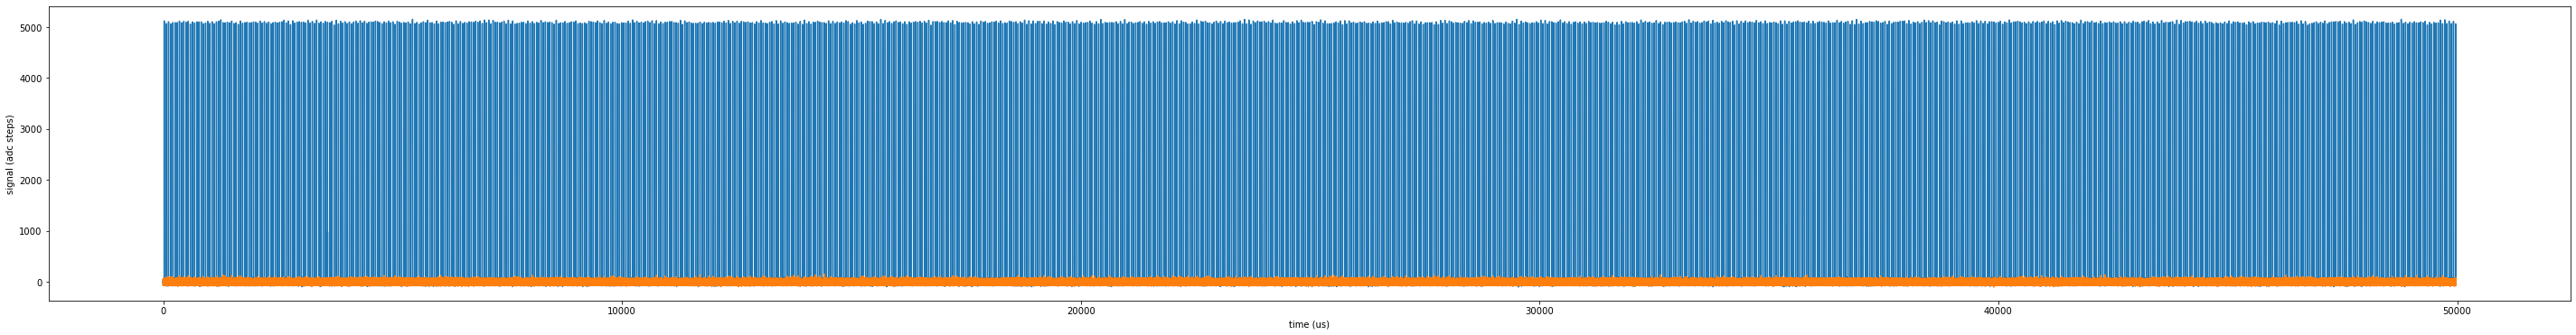

In [8]:
plt.figure(figsize=(50,6))
plt.plot(time_vec*1e6, np.real(orig_data_compl))
plt.plot(time_vec*1e6, np.imag(orig_data_compl))
# plt.xlim([22.2, 23])
plt.xlabel('time (us)')
plt.ylabel('signal (adc steps)')
plt.show()

In [9]:
orig_data_fft = np.fft.fft(orig_data_compl)
freq = np.fft.fftfreq(orig_data_compl.size, d=time_vec[1]-time_vec[0])

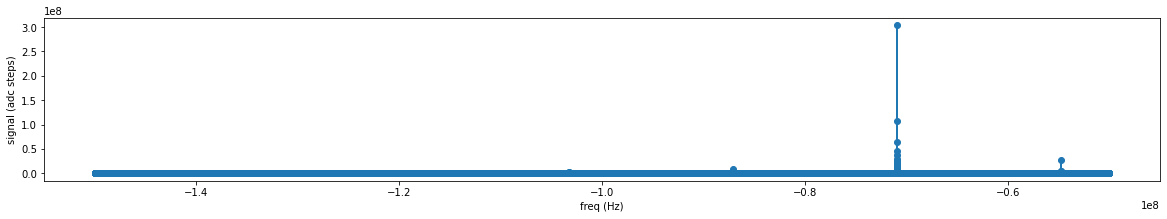

In [10]:
mask = (freq > -150e6) & (freq < -50e6)
plt.figure(figsize=(20,3))
plt.plot(freq[mask], np.abs(orig_data_fft[mask]), '-o')
plt.xlabel('freq (Hz)')
plt.ylabel('signal (adc steps)')
plt.show()